# Notebook Astromark AI

Questo notebook carica i dati dei ticket, li unisce e li preprocessa (utilizzando spaCy per tokenizzazione, lemmatizzazione e NER), costruisce la pipeline di ML, esegue la grid search, salva/carica il modello e infine fornisce un esempio di utilizzo del ticket service.

In [2]:
import sys
import os
import pandas as pd
from service.pipeline import (
    merge_dataframes, 
    dataframe_o3, 
    dataframe_gc, 
    PROCESSED_DATA_PATH, 
    parallel_process_texts, 
    ClassifierType, 
    get_model,
    logger
)

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

### Unione dei dati e preparazione delle variabili  
Questa cella unisce due DataFrame (`dataframe_o3` e `dataframe_gc`) utilizzando la funzione `merge_dataframes`, creando un dataset consolidato.

In [3]:
# Unione dei dati
merged_df = merge_dataframes(dataframe_o3, dataframe_gc)
X = merged_df['titolo_messaggio']
y = merged_df['categoria']
logger.info("Final merged dataset shape: %s", merged_df.shape)

[INFO] Merging dataframes...
[INFO] Eliminated 401 duplicate rows
[INFO] Final merged dataset shape: (5481, 2)


### Visualizzazione della Distribuzione delle Categorie  

Questa cella genera diversi grafici per analizzare la distribuzione delle categorie nel dataset `merged_df`, tra cui un grafico a barre, un grafico a torta, un grafico a barre con percentuali e un box plot della lunghezza del testo.  



Statistiche descrittive per categoria:
categoria
Segreteria    1145
Didattica     1132
Tecnico       1122
Accesso       1050
Profilo       1032
dtype: int64

Percentuali per categoria:
categoria
Segreteria    20.89
Didattica     20.65
Tecnico       20.47
Accesso       19.16
Profilo       18.83
Name: proportion, dtype: float64


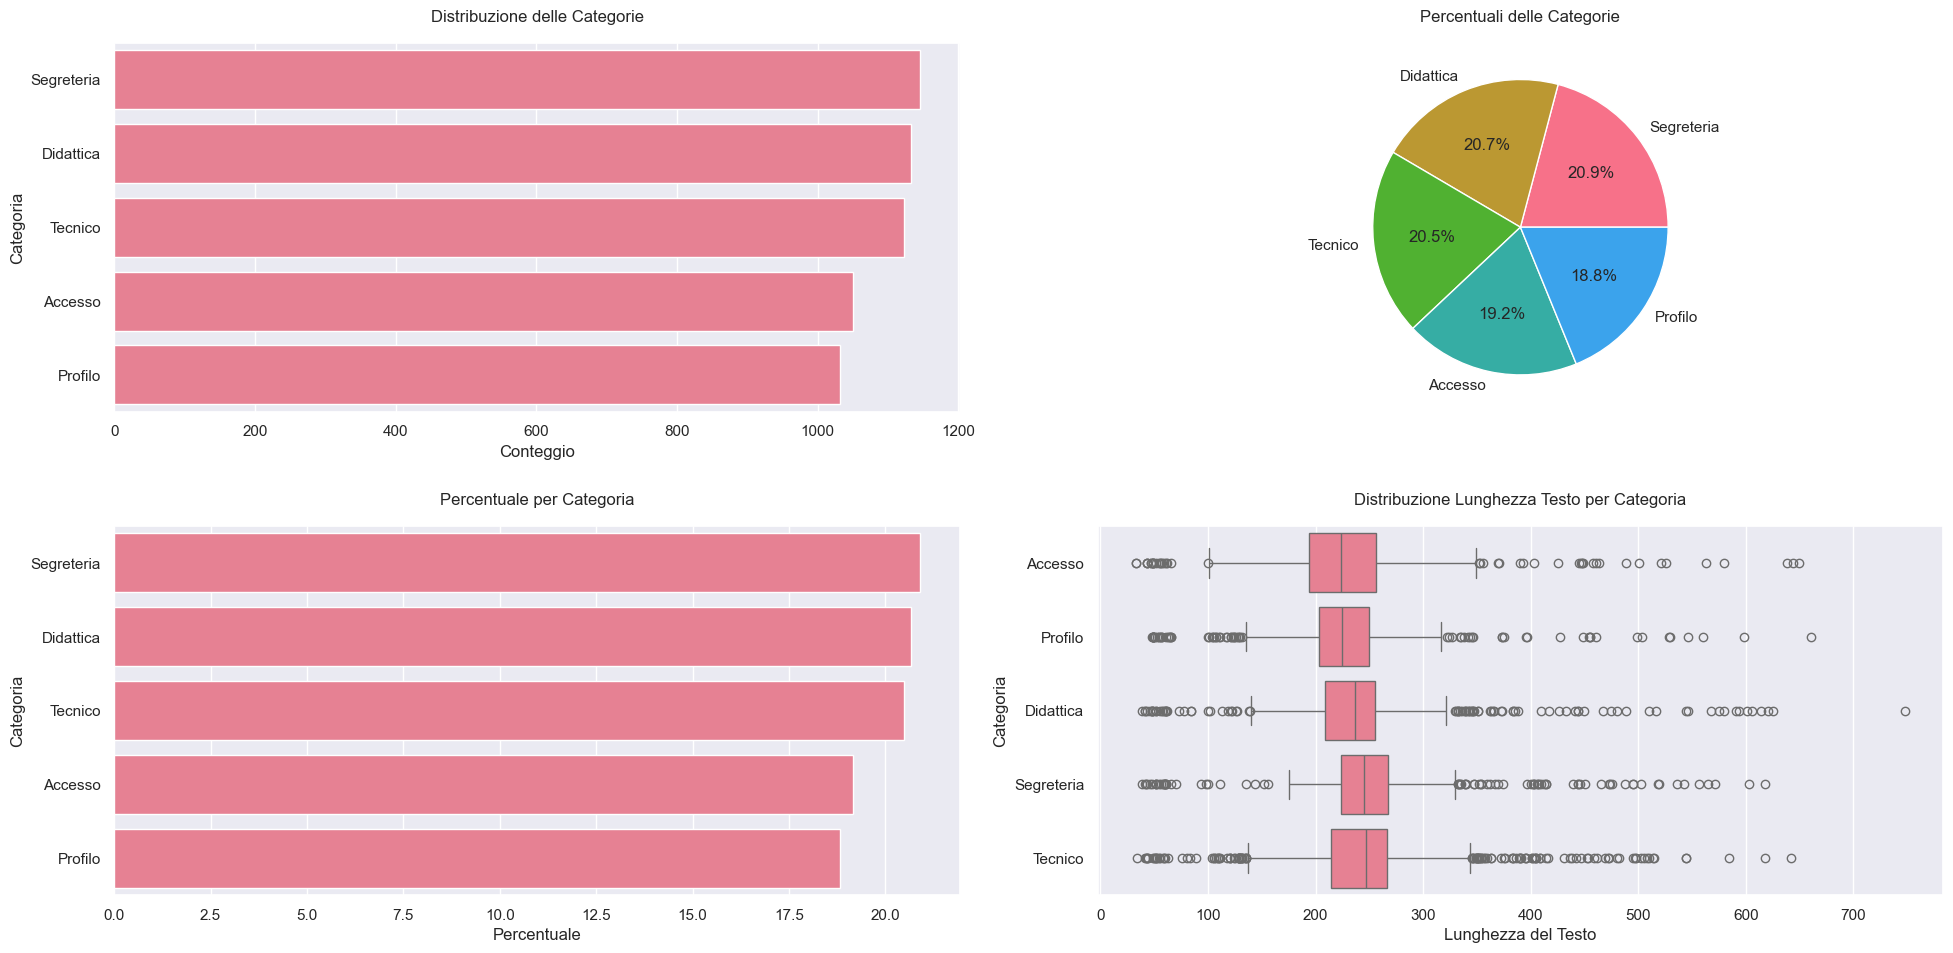

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Impostazioni per una migliore visualizzazione
plt.style.use('default')  # Utilizziamo lo stile default di matplotlib
sns.set_theme()  # Applica il tema base di seaborn
sns.set_palette("husl")

# Creazione di una figura con più sottografici
fig = plt.figure(figsize=(20, 10))

# 1. Grafico a barre della distribuzione delle categorie
plt.subplot(2, 2, 1)
sns.countplot(data=merged_df, y='categoria', order=merged_df['categoria'].value_counts().index)
plt.title('Distribuzione delle Categorie', pad=15)
plt.xlabel('Conteggio')
plt.ylabel('Categoria')

# 2. Grafico a torta delle percentuali
plt.subplot(2, 2, 2)
category_counts = merged_df['categoria'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Percentuali delle Categorie', pad=15)

# 3. Grafico a barre orizzontale con percentuali
plt.subplot(2, 2, 3)
category_percentages = (merged_df['categoria'].value_counts(normalize=True) * 100)
sns.barplot(x=category_percentages.values, y=category_percentages.index)
plt.title('Percentuale per Categoria', pad=15)
plt.xlabel('Percentuale')
plt.ylabel('Categoria')

# 4. Box plot della lunghezza del testo per categoria
plt.subplot(2, 2, 4)
merged_df['text_length'] = merged_df['titolo_messaggio'].str.len()
sns.boxplot(data=merged_df, x='text_length', y='categoria')
plt.title('Distribuzione Lunghezza Testo per Categoria', pad=15)
plt.xlabel('Lunghezza del Testo')
plt.ylabel('Categoria')

# Aggiusta il layout
plt.tight_layout(pad=2.0)

# Mostra statistiche descrittive
print("\nStatistiche descrittive per categoria:")
print(merged_df.groupby('categoria').size().sort_values(ascending=False))
print("\nPercentuali per categoria:")
print(category_percentages.round(2))

# Mostra il plot
plt.show()

### Caricamento o Preprocessing dei Dati  

Questa cella verifica se i dati preprocessati sono già disponibili e, in caso contrario, li elabora e li salva.  


In [6]:
# Carica o processa i dati preprocessati
if os.path.exists(PROCESSED_DATA_PATH):
    logger.info("Loading preprocessed data from '%s'...", PROCESSED_DATA_PATH)
    df = pd.read_csv(PROCESSED_DATA_PATH)
    X_processed = df["processed_text"]
else:
    logger.info("Preprocessed data not found, starting parallel preprocessing...")
    X_processed = parallel_process_texts(X, n_jobs=-1)
    logger.info("Saving preprocessed data to: %s", PROCESSED_DATA_PATH)
    X_processed_df = pd.DataFrame(X_processed, columns=["processed_text"])
    X_processed_df.to_csv(PROCESSED_DATA_PATH, index=False)
    logger.info("Preprocessing complete and cached.")

[INFO] Preprocessed data not found, starting parallel preprocessing...
[INFO] Parallel text processing with threading backend...
[INFO] Saving preprocessed data to: C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\processed\X_processed.csv
[INFO] Preprocessing complete and cached.


## Fine della Pipeline

I dati sono stati caricati, preprocessati e il modello (ottenuto tramite Grid Search) è stato caricato o addestrato e salvato nella cartella `../data/trained`.

### Monitoraggio delle Risorse (CPU e Memoria) Durante l'Addestramento di Naive Bayes  

Questa cella misura l'**andamento dell'uso della CPU e della memoria** durante l'addestramento del classificatore **Naive Bayes**.  


[INFO] Measuring CPU & RAM usage while training naive_bayes...
[INFO] CPU & RAM usage measurement complete.
[INFO] Training finished in 2.45 seconds.
[INFO] Best parameters for naive_bayes: {'clf__alpha': 1.0, 'tfidf__max_df': 0.85, 'tfidf__min_df': 1}


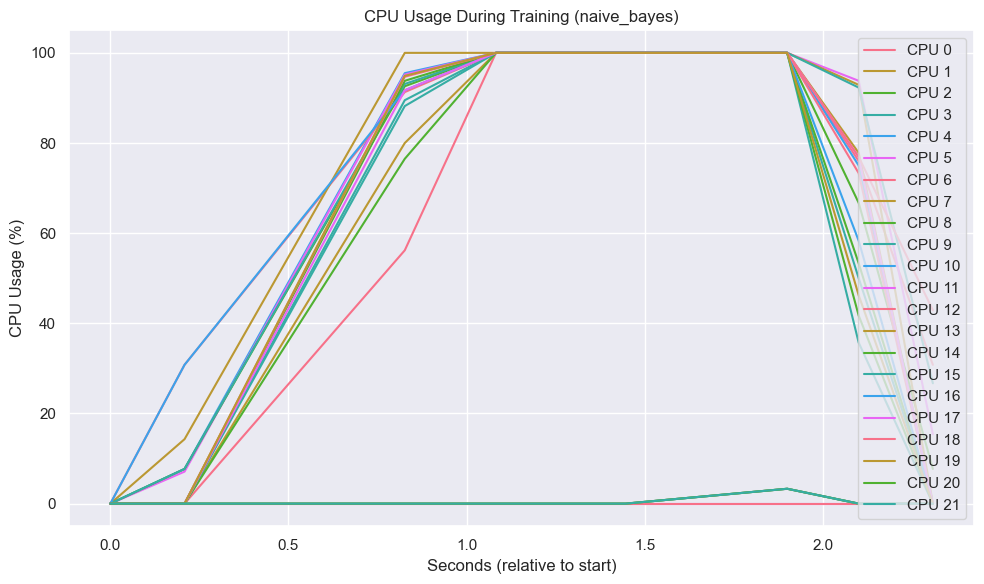

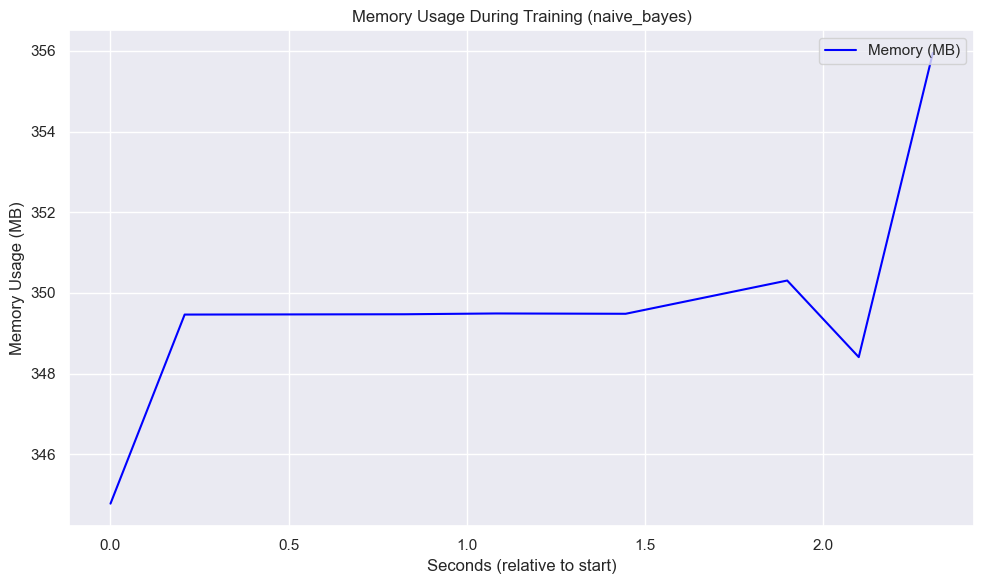

[INFO] Model saved to C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl.


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=3000,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('clf', MultinomialNB())])

In [7]:
from service.report_predict import evaluate_model_with_kfold
from service.pipeline import measure_pc_metrics_during_training
measure_pc_metrics_during_training(ClassifierType.NAIVE_BAYES, save_plot=False)

### Valutazione del Modello Naive Bayes con K-Fold Cross-Validation  

Questa cella esegue una **validazione incrociata (K-Fold cross-validation)** per il classificatore **Naive Bayes**, utilizzando il dataset `X_processed` per le caratteristiche e `y` per le etichette.  


[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


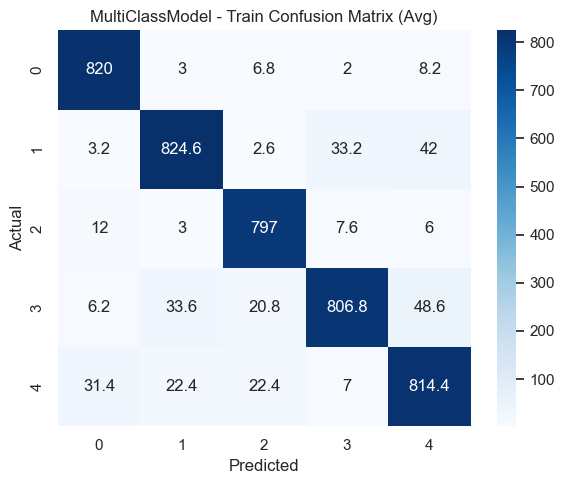

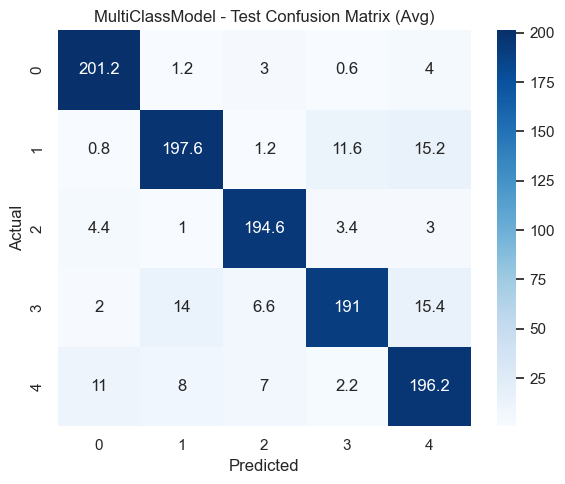

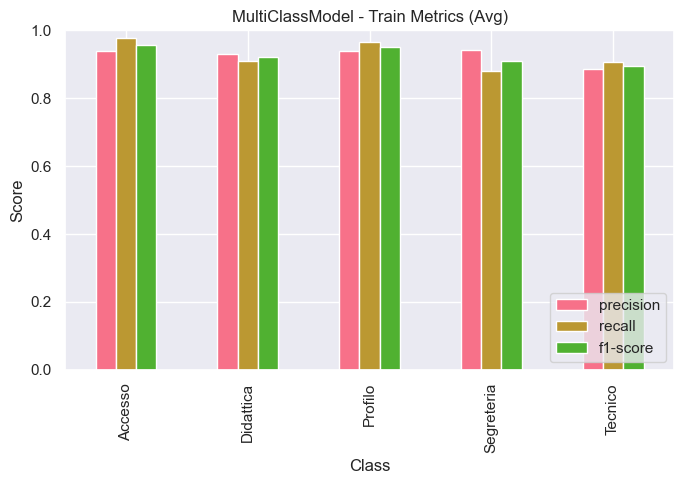

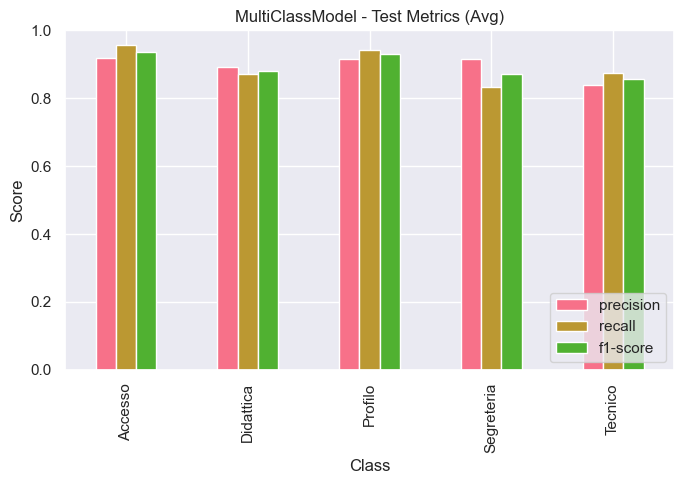

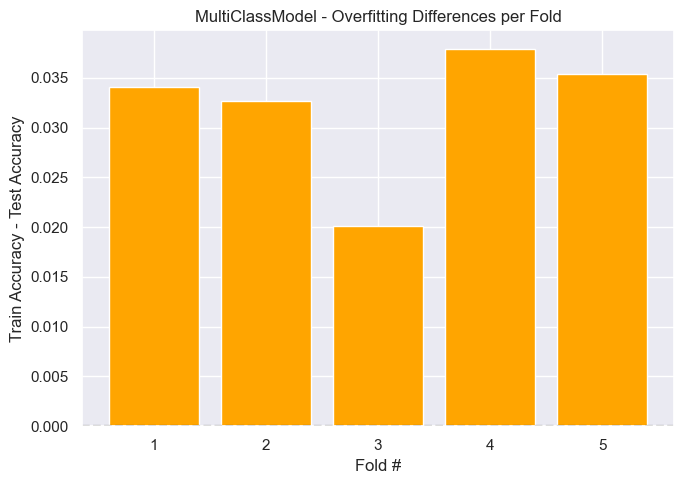

{'train': {'accuracy': 0.9265645781487987,
  'confusion_matrix': array([[820. ,   3. ,   6.8,   2. ,   8.2],
         [  3.2, 824.6,   2.6,  33.2,  42. ],
         [ 12. ,   3. , 797. ,   7.6,   6. ],
         [  6.2,  33.6,  20.8, 806.8,  48.6],
         [ 31.4,  22.4,  22.4,   7. , 814.4]]),
  'report_df':               precision    recall  f1-score      support
  Accesso        0.939517  0.976190  0.957499   840.000000
  Didattica      0.930073  0.910557  0.920208   905.600000
  Profilo        0.938091  0.965360  0.951529   825.600000
  Segreteria     0.941863  0.880786  0.910290   916.000000
  Tecnico        0.886030  0.907307  0.896527   897.600000
  accuracy       0.926565  0.926565  0.926565     0.926565
  macro avg      0.927115  0.928040  0.927211  4384.800000
  weighted avg   0.926839  0.926565  0.926330  4384.800000},
 'test': {'accuracy': 0.8945448436013281,
  'confusion_matrix': array([[201.2,   1.2,   3. ,   0.6,   4. ],
         [  0.8, 197.6,   1.2,  11.6,  15.2],
     

In [8]:
evaluate_model_with_kfold(get_model(ClassifierType.NAIVE_BAYES), X_processed, y)

### Monitoraggio delle Risorse (CPU e Memoria) Durante l'Addestramento di SVM

Questa cella misura l'**andamento dell'uso della CPU e della memoria** durante l'addestramento del classificatore **SVM**.  


[INFO] Measuring CPU & RAM usage while training svm...
[INFO] CPU & RAM usage measurement complete.
[INFO] Training finished in 85.79 seconds.
[INFO] Best parameters for svm: {'clf__C': 1.0, 'svd__n_components': 100, 'tfidf__max_df': 0.85, 'tfidf__min_df': 3}


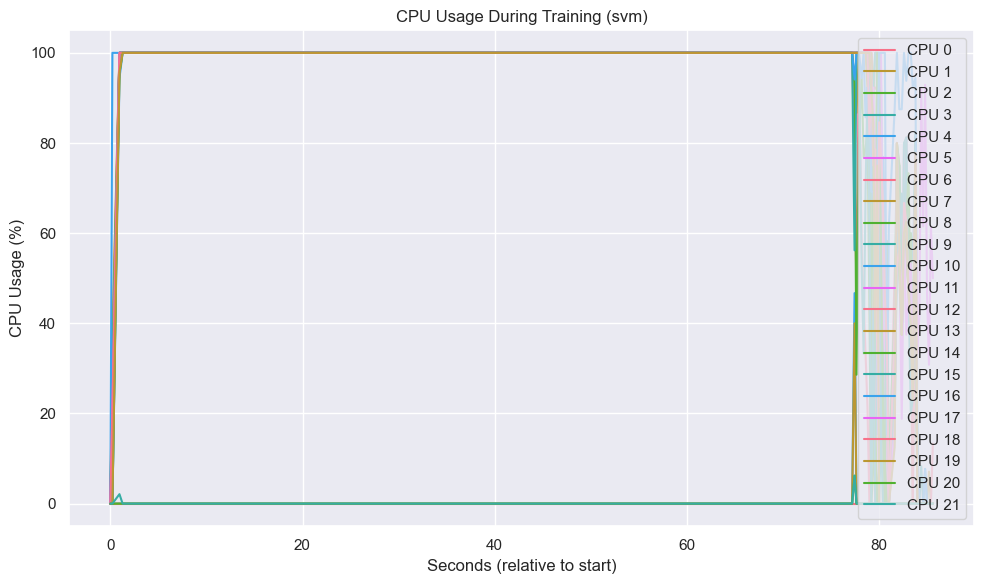

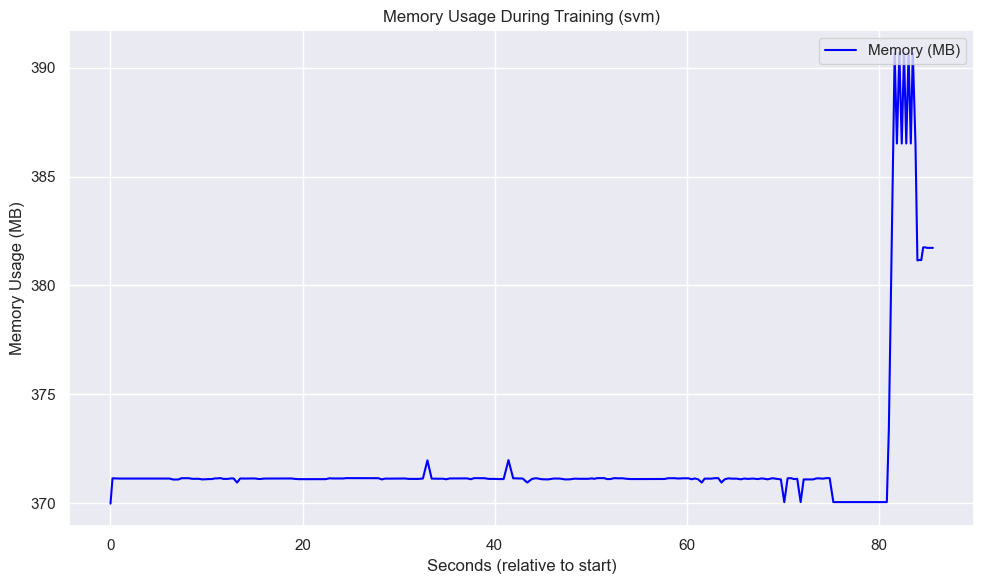

[INFO] Model saved to C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_svm.pkl.


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=3000, min_df=3,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('svd', TruncatedSVD(n_components=100, random_state=42)),
                ('clf',
                 SVC(kernel='linear', probability=True, random_state=42))])

In [9]:
measure_pc_metrics_during_training(ClassifierType.SVM, save_plot=False)

### Valutazione del Modello SVM con K-Fold Cross-Validation  

Questa cella esegue una **validazione incrociata (K-Fold cross-validation)** per il classificatore **SVM**, utilizzando il dataset `X_processed` per le caratteristiche e `y` per le etichette. 

[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


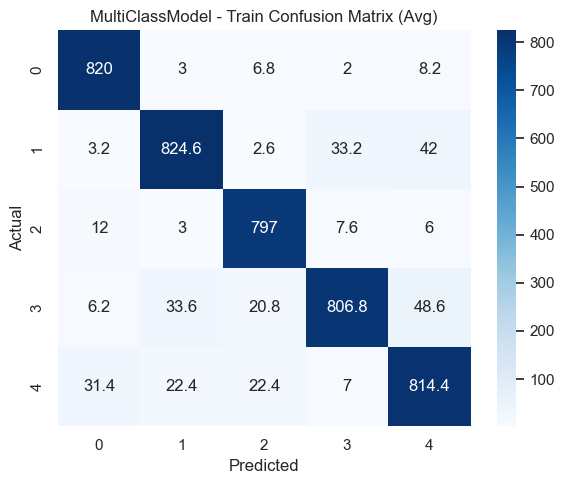

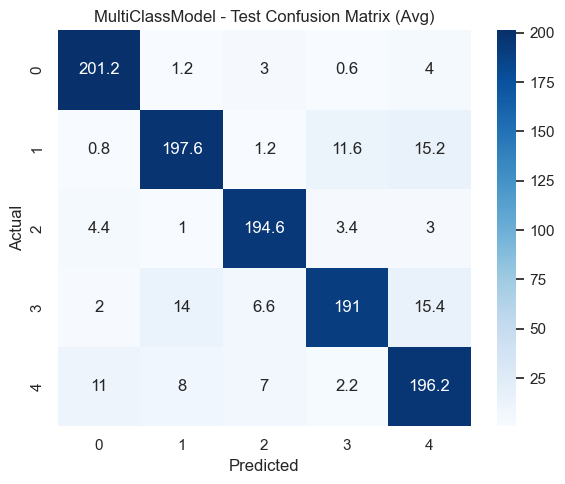

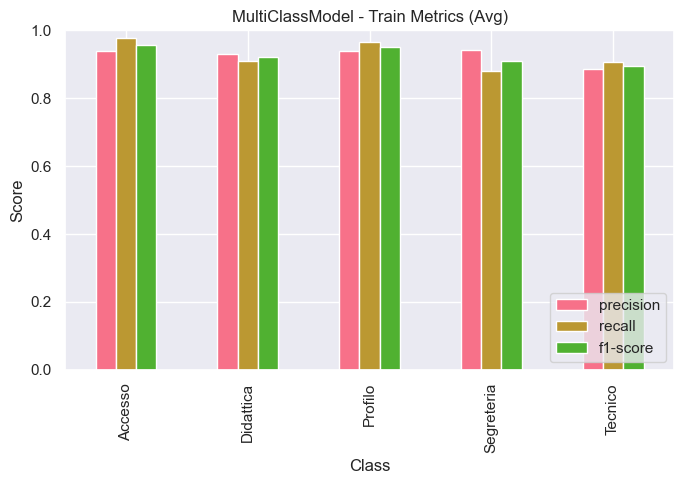

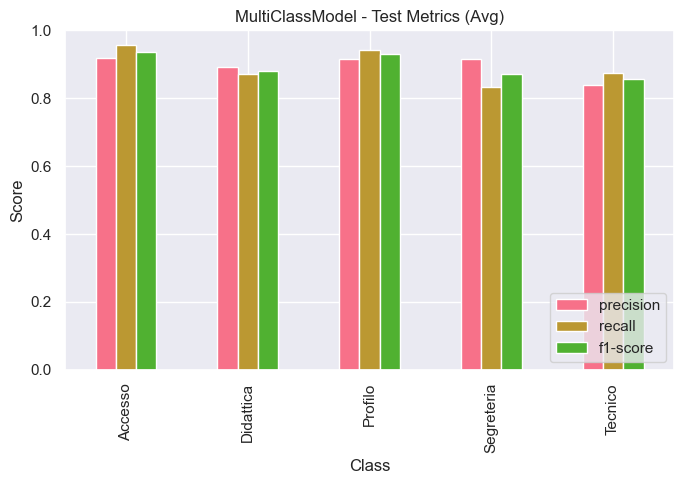

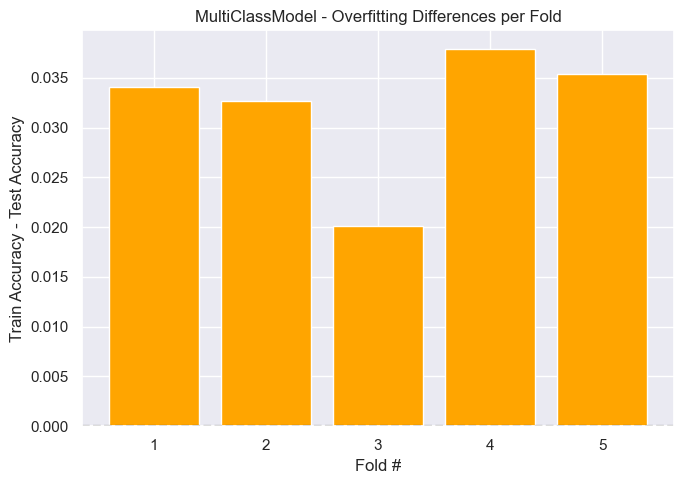

{'train': {'accuracy': 0.9265645781487987,
  'confusion_matrix': array([[820. ,   3. ,   6.8,   2. ,   8.2],
         [  3.2, 824.6,   2.6,  33.2,  42. ],
         [ 12. ,   3. , 797. ,   7.6,   6. ],
         [  6.2,  33.6,  20.8, 806.8,  48.6],
         [ 31.4,  22.4,  22.4,   7. , 814.4]]),
  'report_df':               precision    recall  f1-score      support
  Accesso        0.939517  0.976190  0.957499   840.000000
  Didattica      0.930073  0.910557  0.920208   905.600000
  Profilo        0.938091  0.965360  0.951529   825.600000
  Segreteria     0.941863  0.880786  0.910290   916.000000
  Tecnico        0.886030  0.907307  0.896527   897.600000
  accuracy       0.926565  0.926565  0.926565     0.926565
  macro avg      0.927115  0.928040  0.927211  4384.800000
  weighted avg   0.926839  0.926565  0.926330  4384.800000},
 'test': {'accuracy': 0.8945448436013281,
  'confusion_matrix': array([[201.2,   1.2,   3. ,   0.6,   4. ],
         [  0.8, 197.6,   1.2,  11.6,  15.2],
     

In [10]:
evaluate_model_with_kfold(get_model(ClassifierType.NAIVE_BAYES), X_processed, y)

### Confronto tra Classificatori Naive Bayes e SVM con K-Fold Cross-Validation  

Questa cella esegue un **confronto tra due classificatori** (Naive Bayes e SVM) utilizzando la **validazione incrociata K-Fold** su tutto il dataset preprocessato. I risultati vengono calcolati per ogni fold e vengono comparati per determinare quale classificatore offre le migliori prestazioni.  


[INFO] Starting K-Fold comparison of Naive Bayes vs. SVM...
[INFO] Comparing Naive Bayes vs. SVM with 5-fold cross-validation...
[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.
[INFO] Evaluating Naive Bayes with KFold...
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


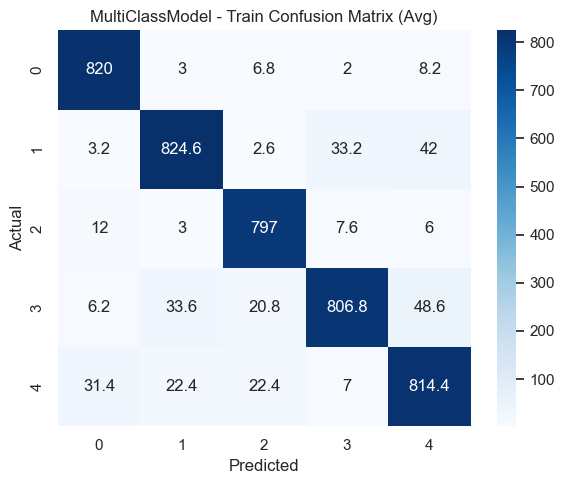

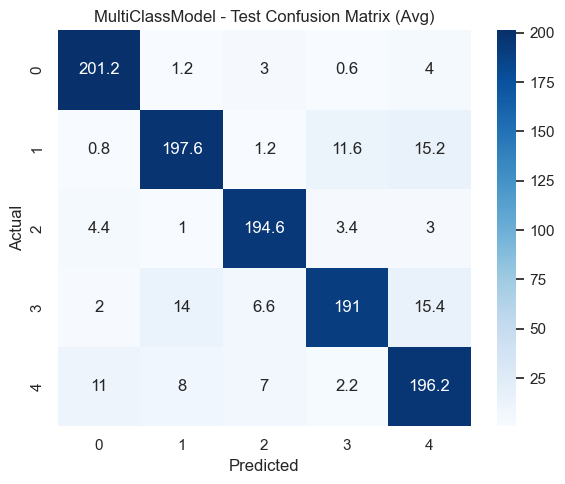

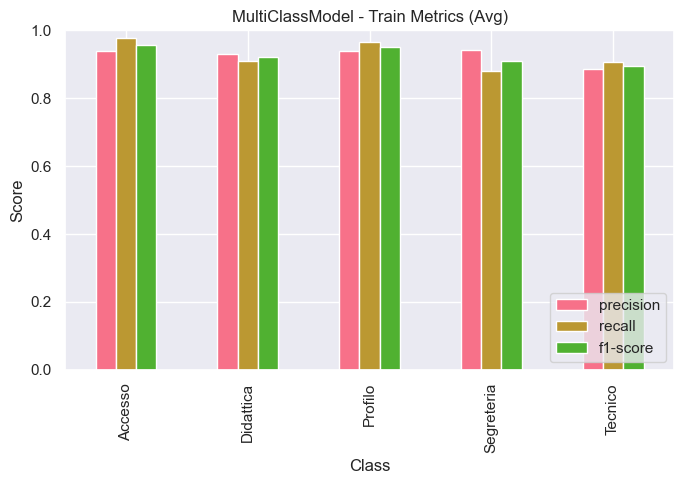

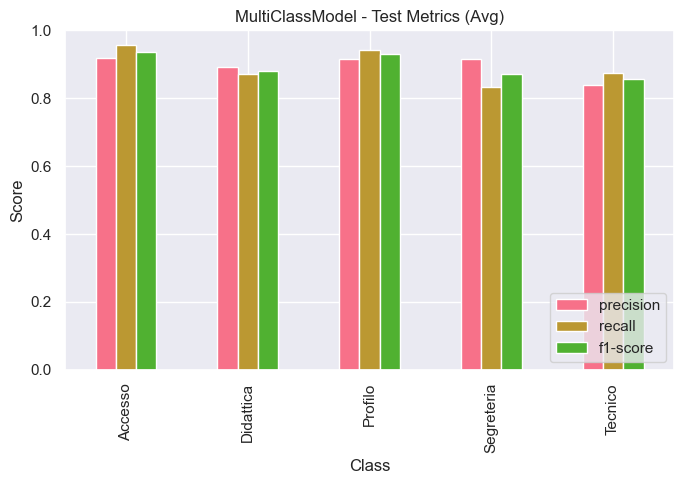

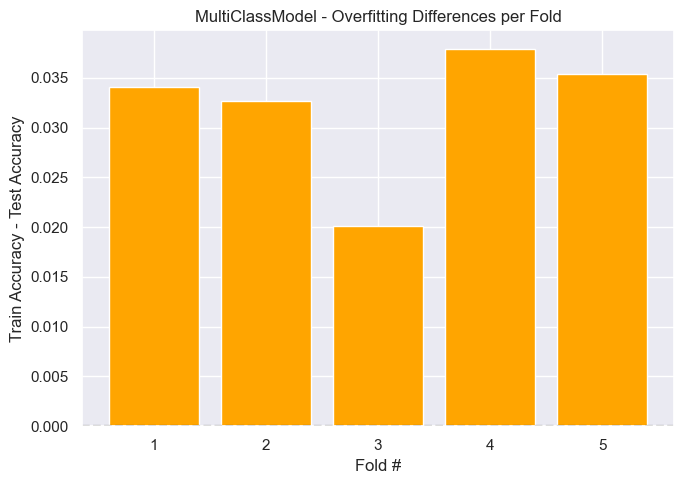

[INFO] Evaluating SVM with KFold...
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


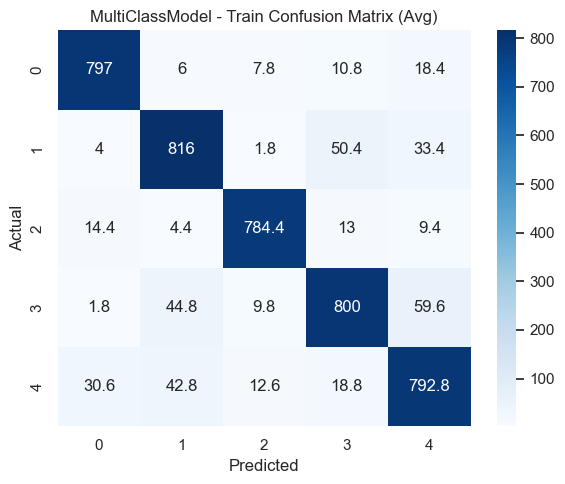

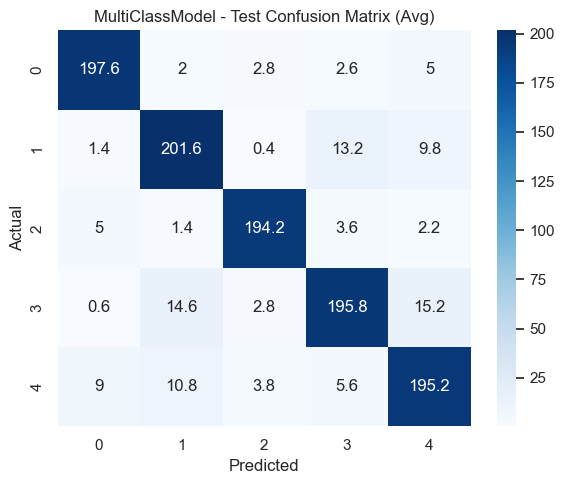

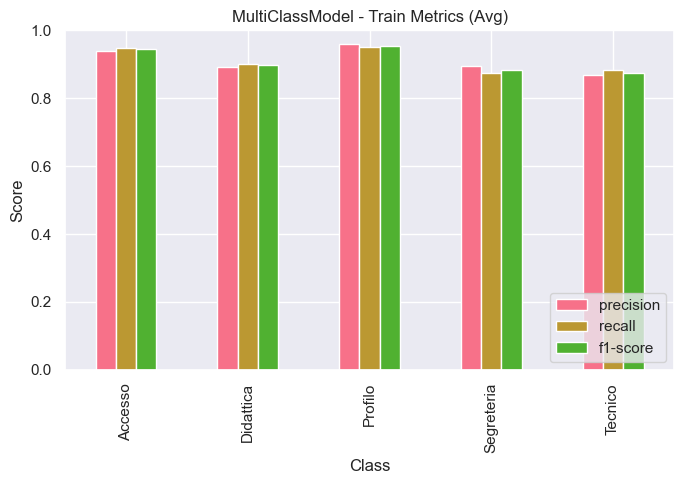

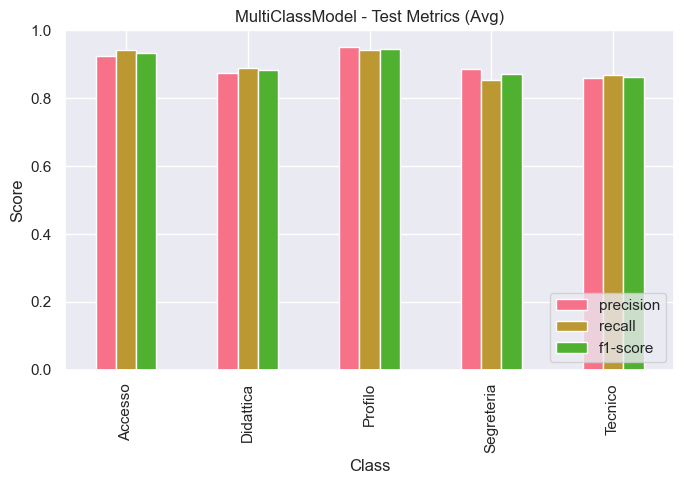

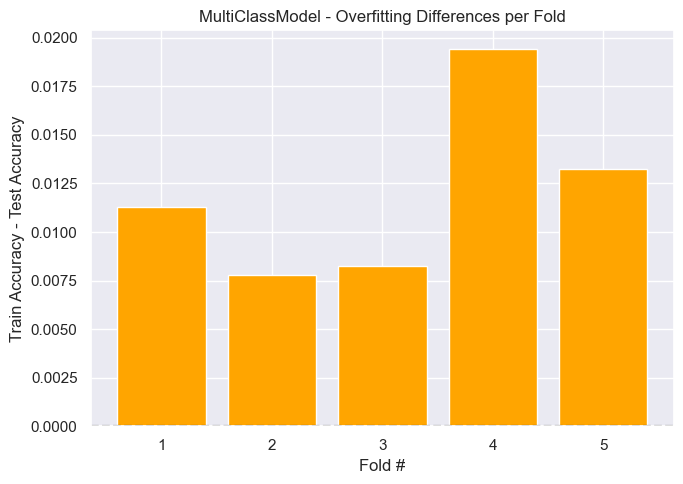

[INFO] KFold Comparison:
 Classifier  Train Accuracy  Test Accuracy  Overfitting (Train-Test)
Naive_Bayes        0.926565       0.894545                  0.032020
        SVM        0.910007       0.898012                  0.011996


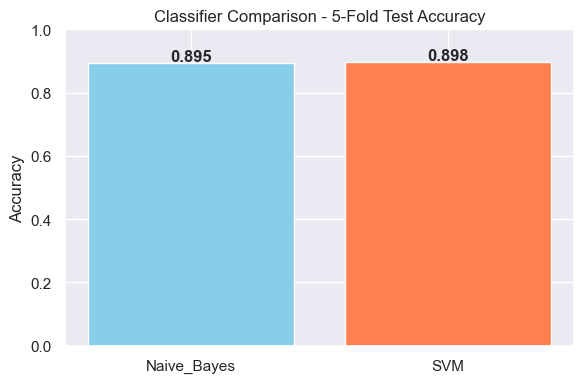

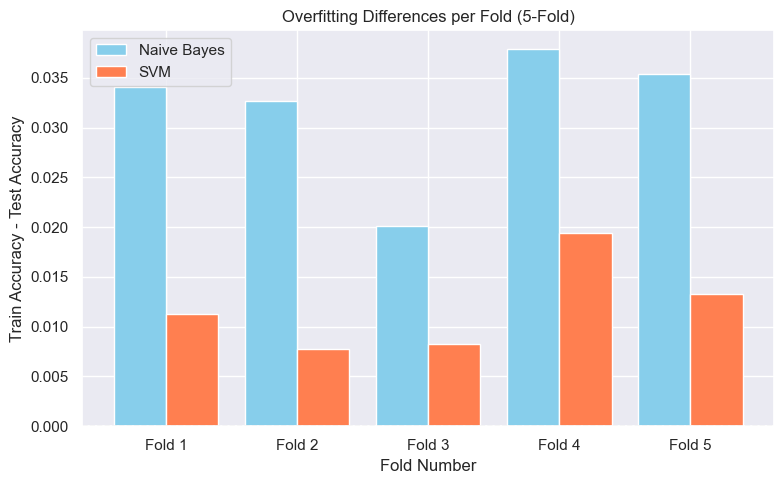

Comparison Results (Naive Bayes vs. SVM):


' Classifier  Train Accuracy  Test Accuracy  Overfitting (Train-Test)\nNaive_Bayes        0.926565       0.894545                  0.032020\n        SVM        0.910007       0.898012                  0.011996'

In [11]:
from service.report_predict import compare_classifiers_with_kfold

# Example usage of compare_classifiers_with_kfold
logger.info("Starting K-Fold comparison of Naive Bayes vs. SVM...")

# Use the entire preprocessed dataset
X_small, y_small = X_processed, y

# Compare the two classifiers with 5-fold CV,
# saving both the plots and the resulting DataFrame.
df_results = compare_classifiers_with_kfold(
    X_small,
    y_small,
    n_splits=5,
    shuffle=True,
    random_state=42,
    save_plots=False,  # True -> saves bar charts
    save_data=False  # True -> saves the final df_compare to CSV
)

print("Comparison Results (Naive Bayes vs. SVM):")
df_results.to_string(index=False)

## Fase di Controllo e Valutazione Completata - Passiamo all'Utilizzo del Dataset
Esempio di Funzione del Ticket Service: Classificazione del Messaggio

In [12]:
# Esempio: Funzione per il Ticket Service
def ticket_service(title, message, classifier_type):
    get_model(classifier_type)
    full_text = f"{title} {message}".strip()
    if not full_text:
        return ["Nessun input fornito"]
    # Importa la funzione predict_category dal modulo report_predict
    from service.report_predict import predict_category
    predictions = predict_category(full_text, classifier_type)
    print("Predizioni:", predictions)
    return predictions

### Esempio di utilizzo con SVM

In [13]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
pd.DataFrame(ticket_service(example_title, example_message, ClassifierType.SVM), columns=["Class", "Probability"])

[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.
[INFO] Predicting category for a new message...
[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.


Predizioni: [('Tecnico', np.float64(0.9661426158308837)), ('Accesso', np.float64(0.01461225347401016)), ('Segreteria', np.float64(0.012866535828394435))]


,Class,Probability
0,Tecnico,0.966143
1,Accesso,0.014612
2,Segreteria,0.012867


### Esempio di utilizzo con NAIVE BAYES

In [14]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
pd.DataFrame(ticket_service(example_title, example_message, ClassifierType.NAIVE_BAYES), columns=["Class", "Probability"])

[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] Predicting category for a new message...
[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.


Predizioni: [(np.str_('Tecnico'), np.float64(0.8150991480255185)), (np.str_('Accesso'), np.float64(0.07634469802094611)), (np.str_('Didattica'), np.float64(0.03960978882745219))]


,Class,Probability
0,Tecnico,0.815099
1,Accesso,0.076345
2,Didattica,0.039610
